In [4]:
from itertools import product

import copy
from torch import cuda
from torch.nn import Module, RNN, GRU, LSTM, Linear, CrossEntropyLoss
from torch.nn.utils import clip_grad_norm_
from torch.optim.adam import Adam
from torch.utils.data import DataLoader

from typing import Tuple

import torch
from torch import Tensor, zeros
from torch.utils.data import Dataset

from LAB3_1.utils import compute_acc, Sequential_mnist , show_loss

In [7]:
gpu = 'cuda' if cuda.is_available() else 'cpu'

## Model

In [8]:
class Recurrent_RNN(Module): # Recurrent Neural network
    def __init__(self,rnn_type:str, hidden: int, layers:int, bi:bool):
        super(Recurrent_RNN, self).__init__()

        if rnn_type == "RNN":
            self.rnn = RNN(1, hidden, num_layers=layers, bidirectional=bi, batch_first=True)
        elif rnn_type == "LSTM":
            self.rnn = LSTM(1, hidden, num_layers=layers, bidirectional=bi, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = GRU(1, hidden, num_layers=layers, bidirectional=bi, batch_first=True)

        B = 2 if bi else 1
        self.readout = Linear(B * hidden, 10)
        self.criteria = CrossEntropyLoss()

    def forward(self, x: Tensor, y:Tensor=None) -> Tensor:
        self.rnn.flatten_parameters()
        out, _ = self.rnn(x)
        y_pred =  self.readout(out[:,-1,:]) # take only the last hidden state as (cumulative knowledge)

        loss = None
        if y is not None:
            loss = self.criteria(y_pred, y)
        return (loss, y_pred) if loss is not None else y_pred

## Trainer

In [9]:
class RNN_trainer:
    def __init__(self, rnn_type:str, hidden:int, layers:int, bi:bool):

        # model
        self.model = Recurrent_RNN(rnn_type, hidden=hidden, layers=layers, bi=bi).to(gpu)

    def fit(self, dataset:Dataset, epochs:int=2, lr:float=0.001):

        # Build a dataloader with the training dataset
        loader = DataLoader(dataset, batch_size=64, shuffle=True)
        opt = Adam(self.model.parameters(), lr)
        history_tr = zeros(epochs) # keep track the loss and accuracy through epochs

        loss, y, y_pred =  None, None, None

        self.model.train()
        for i in range(epochs):

            for x, y in loader:
                x,y = x.to(gpu), y.to(gpu)

                opt.zero_grad(set_to_none=True)
                loss, y_pred = self.model(x, y)
                loss.backward()
                clip_grad_norm_(self.model.parameters(), 1)
                opt.step()

            history_tr[i] = loss.item()
            if i % 15 == 0:
                print(f'Epoch {i} Loss: {round(loss.item(), 4)} Accuracy {round(compute_acc(y_pred, y), 4)}')

        return history_tr

    def validate(self, dataset:Dataset) -> Tuple:
        # Build a dataloader with the dataset taken (train, validation or test)
        loader = DataLoader(dataset, batch_size=64)
        cum_loss, cum_acc = 0, 0

        self.model.eval()
        with torch.no_grad():
            for x, y in loader:
                x,y = x.to(gpu), y.to(gpu)
                loss, y_pred = self.model(x, y)
                cum_loss += loss.item()
                cum_acc += compute_acc(y_pred, y)

        cum_loss /= len(loader)
        cum_acc /= len(loader)

        return  cum_loss, cum_acc

In [10]:
class GridSearch:

    def __init__(self, rnn_type:str, parameters_grid:dict, tr:Dataset, dev:Dataset):

        self.rnn_type = rnn_type
        all_configs = [dict(zip(parameters_grid.keys(), configs)) for configs in product(*parameters_grid.values())]

        print("Number of configurations to try: ",len(all_configs))
        # returns the performance in each configuration, the best model and the history of the loss
        rank, best, loss = self.run(tr, dev, all_configs)

        # we sort by validation loss
        rank = sorted(rank, key=lambda conf: -conf[2])

        print("\nThe best solution in ", rank[0])
        self.best_config = rank[0][0]
        self.best_model = best
        self.tr_loss = loss

    def run(self, tr:Dataset, dev:Dataset, configs:list):
        """
        In the grid search, we explore all configurations provided and try to find the best
        hyperparameter configuration using the training set to train the model and the validation
        set to compare the performance among all models instantiated by configurations.
        """

        rank = [] # the keep in track the configuration and the corresponding performance

        # we save the best trained model and the training loss during the epochs
        best, loss = None, None
        best_dev_acc = 0

        for idx, config in enumerate(configs):
            print("Config: ",idx)

            trainer = RNN_trainer(rnn_type=self.rnn_type,
                                  hidden=config["units"],
                                  layers=config["layers"],
                                  bi=config["bi"])

            history  = trainer.fit(tr, config["epochs"], config["lr"])
            _, acc_vl = trainer.validate(dev)

            rank.append((config, round(history[-1].item(), 4), round(acc_vl, 4)))

            print(f'Results: Acc tr: {round(history[-1].item(), 4)}', f'Acc vl: {round(acc_vl, 4)}')

            # we keep the best model
            if best_dev_acc < acc_vl:
                best_dev_acc = acc_vl
                loss = copy.deepcopy(history)
                best = copy.deepcopy(trainer)

        return rank, best, loss

# Bonus-Track Assignment 2: Sequential MNIST classification task

## Retrieve the dataset and Hold out

In [11]:
tr_dataset = Sequential_mnist("train")
dev_dataset = Sequential_mnist("dev")
ts_dataset = Sequential_mnist("test")

100%|██████████| 9912422/9912422 [00:00<00:00, 484232418.78it/s]

Extracting sources/MNIST/raw/train-images-idx3-ubyte.gz to sources/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 95987079.10it/s]


Extracting sources/MNIST/raw/train-labels-idx1-ubyte.gz to sources/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 163523311.11it/s]

Extracting sources/MNIST/raw/t10k-images-idx3-ubyte.gz to sources/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 6169212.68it/s]


Extracting sources/MNIST/raw/t10k-labels-idx1-ubyte.gz to sources/MNIST/raw



## Grid search Vanilla RNN

In [12]:
ranges_to_explore = {
    "units" : [10, 20],
    "epochs" : [100],
    "lr" : [0.001, 0.004],
    "layers": [1, 2],
    "bi" : [True]
}

In [ ]:
gs = GridSearch("RNN", ranges_to_explore, tr_dataset, dev_dataset)
best_config =  gs.best_config
best_model = gs.best_model

Number of configurations to try:  4
Config:  0
{'units': 10, 'epochs': 100, 'lr': 0.001, 'layers': 1, 'bi': True}
Epoch 0 Loss: 2.3259 Accuracy 0.0
Epoch 5 Loss: 2.3264 Accuracy 0.0
Epoch 10 Loss: 2.3267 Accuracy 0.0
Epoch 15 Loss: 2.3267 Accuracy 0.0
Epoch 20 Loss: 2.3267 Accuracy 0.0
Epoch 25 Loss: 2.3267 Accuracy 0.0
Epoch 30 Loss: 2.3269 Accuracy 0.0
Epoch 35 Loss: 2.3274 Accuracy 0.0
Epoch 40 Loss: 2.3012 Accuracy 0.1875
Epoch 45 Loss: 2.2962 Accuracy 0.125
Epoch 50 Loss: 2.3342 Accuracy 0.1875
Epoch 55 Loss: 1.8766 Accuracy 0.3125
Epoch 60 Loss: 1.9966 Accuracy 0.1875
Epoch 65 Loss: 1.8934 Accuracy 0.375
Epoch 70 Loss: 1.8631 Accuracy 0.3125
Epoch 75 Loss: 1.8869 Accuracy 0.25
Epoch 80 Loss: 2.1034 Accuracy 0.25
Epoch 85 Loss: 1.7794 Accuracy 0.25
Epoch 90 Loss: 1.9953 Accuracy 0.1875
Epoch 95 Loss: 1.7925 Accuracy 0.3125
Results: Acc tr: 1.8371 Acc vl: 0.2446
Best model than the previous one
Config:  1
{'units': 10, 'epochs': 100, 'lr': 0.001, 'layers': 2, 'bi': True}
Epoch 0 Lo

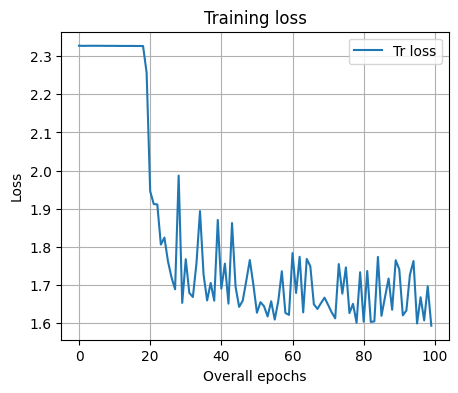

In [ ]:
show_loss(gs.tr_loss)

In [ ]:
tr_loss, tr_acc = best_model.validate(tr_dataset)
print(f'Train loss: {round(tr_loss, 6)}', f'Accuracy: {round(tr_acc, 3)}')

dev_loss, dev_acc = best_model.validate(dev_dataset)
print(f'Train loss: {round(dev_loss, 6)}', f'Accuracy: {round(dev_acc, 3)}')

test_loss, test_acc = best_model.validate(ts_dataset)
print(f'Train loss: {round(test_loss, 6)}', f'Accuracy: {round(test_acc, 3)}')

Train loss: 1.852718 Accuracy: 0.293
Train loss: 1.802062 Accuracy: 0.303
Train loss: 1.849722 Accuracy: 0.294


#### Final retrain with Training and Validation set (with the best configuration)

In [ ]:
best_rrn_model = RNN_trainer(rnn_type="RNN",
                            hidden=best_config["units"],
                            layers=best_config["layers"],
                            bi=best_config["bi"])
# we use both training and validation as a training set, using the best parameters
# found in the previous model selection
final_tr = Sequential_mnist("train-dev")
best_rrn_model.fit(final_tr, best_config["epochs"], lr=best_config["lr"])

tr_loss, tr_acc = best_rrn_model.validate(final_tr)
print(f'Train loss: {round(tr_loss, 6)}', f'Accuracy: {round(tr_acc, 3)}')

test_loss, test_acc  = best_rrn_model.validate(ts_dataset)
print(f'Train loss: {round(test_loss, 6)}', f'Accuracy: {round(test_acc, 3)}')

Epoch 0 Loss: 2.3093 Accuracy 0.0625
Epoch 5 Loss: 2.3104 Accuracy 0.0625
Epoch 10 Loss: 2.3096 Accuracy 0.0625
Epoch 15 Loss: 2.3091 Accuracy 0.0625
Epoch 20 Loss: 2.309 Accuracy 0.0625
Epoch 25 Loss: 2.3087 Accuracy 0.0625
Epoch 30 Loss: 2.2991 Accuracy 0.0625
Epoch 35 Loss: 2.1233 Accuracy 0.1562
Epoch 40 Loss: 1.7981 Accuracy 0.2812
Epoch 45 Loss: 1.5589 Accuracy 0.4062
Epoch 50 Loss: 1.4389 Accuracy 0.375
Epoch 55 Loss: 1.6365 Accuracy 0.375
Epoch 60 Loss: 1.4032 Accuracy 0.4062
Epoch 65 Loss: 1.3609 Accuracy 0.4688
Epoch 70 Loss: 1.4681 Accuracy 0.3438
Epoch 75 Loss: 1.3583 Accuracy 0.4688
Epoch 80 Loss: 1.5149 Accuracy 0.3125
Epoch 85 Loss: 1.1383 Accuracy 0.5625
Epoch 90 Loss: 1.0885 Accuracy 0.5625
Epoch 95 Loss: 1.2974 Accuracy 0.375
Train loss: 1.515966 Accuracy: 0.404
Train loss: 1.532111 Accuracy: 0.396


In [ ]:
best_rrn_model = RNN_trainer(rnn_type="RNN",
                            hidden=best_config["units"],
                            layers=best_config["layers"],
                            bi=best_config["bi"])
# we use both training and validation as a training set, using the best parameters
# found in the previous model selection
final_tr = Sequential_mnist("train-dev")
tr_history = best_rrn_model.fit(final_tr, best_config["epochs"], lr=best_config["lr"])

tr_loss, tr_acc = best_rrn_model.validate(final_tr)
print(f'Train loss: {round(tr_loss, 6)}', f'Accuracy: {round(tr_acc, 3)}')

test_loss, test_acc  = best_rrn_model.validate(ts_dataset)
print(f'Train loss: {round(test_loss, 6)}', f'Accuracy: {round(test_acc, 3)}')

Epoch 0 Loss: 2.3093 Accuracy 0.0625
Epoch 5 Loss: 2.3104 Accuracy 0.0625
Epoch 10 Loss: 2.3096 Accuracy 0.0625
Epoch 15 Loss: 2.3091 Accuracy 0.0625
Epoch 20 Loss: 2.309 Accuracy 0.0625
Epoch 25 Loss: 2.3087 Accuracy 0.0625
Epoch 30 Loss: 2.2991 Accuracy 0.0625
Epoch 35 Loss: 2.1233 Accuracy 0.1562
Epoch 40 Loss: 1.7981 Accuracy 0.2812
Epoch 45 Loss: 1.5589 Accuracy 0.4062
Epoch 50 Loss: 1.4389 Accuracy 0.375
Epoch 55 Loss: 1.6365 Accuracy 0.375
Epoch 60 Loss: 1.4032 Accuracy 0.4062
Epoch 65 Loss: 1.3609 Accuracy 0.4688
Epoch 70 Loss: 1.4681 Accuracy 0.3438
Epoch 75 Loss: 1.3583 Accuracy 0.4688
Epoch 80 Loss: 1.5149 Accuracy 0.3125
Epoch 85 Loss: 1.1383 Accuracy 0.5625
Epoch 90 Loss: 1.0885 Accuracy 0.5625
Epoch 95 Loss: 1.2974 Accuracy 0.375
Train loss: 1.515966 Accuracy: 0.404
Train loss: 1.532111 Accuracy: 0.396


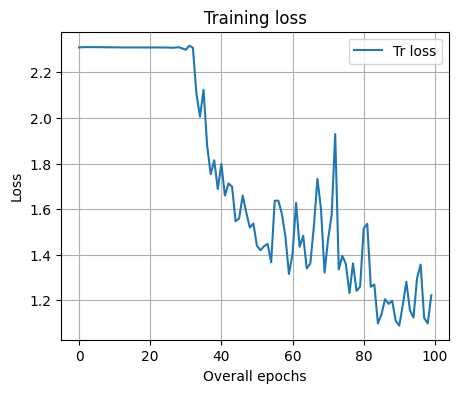

In [ ]:
show_loss(tr_history)

# Bonus Track Assignment 4: benchmarking RNN models on the sequential MNIST task

## Grid search LSTM

In [13]:
gs = GridSearch("LSTM",ranges_to_explore, tr_dataset, dev_dataset)
best_config =  gs.best_config
best_model = gs.best_model

Number of configurations to try:  8
Config:  0
Epoch 0 Loss: 2.3266 Accuracy 0.0
Epoch 15 Loss: 1.7534 Accuracy 0.1875
Epoch 30 Loss: 1.484 Accuracy 0.5
Epoch 45 Loss: 1.3548 Accuracy 0.5625
Epoch 60 Loss: 1.2062 Accuracy 0.625
Epoch 75 Loss: 1.123 Accuracy 0.625
Epoch 90 Loss: 1.1282 Accuracy 0.5625
Results: Acc tr: 1.1421 Acc vl: 0.6164
Config:  1
Epoch 0 Loss: 2.3268 Accuracy 0.0
Epoch 15 Loss: 1.3784 Accuracy 0.5
Epoch 30 Loss: 1.1445 Accuracy 0.625
Epoch 45 Loss: 1.1209 Accuracy 0.25
Epoch 60 Loss: 0.6628 Accuracy 0.6875
Epoch 75 Loss: 0.3496 Accuracy 0.875
Epoch 90 Loss: 0.1421 Accuracy 1.0
Results: Acc tr: 0.0786 Acc vl: 0.9486
Config:  2
Epoch 0 Loss: 2.3248 Accuracy 0.0
Epoch 15 Loss: 2.3274 Accuracy 0.0
Epoch 30 Loss: 2.3274 Accuracy 0.0
Epoch 45 Loss: 2.3274 Accuracy 0.0
Epoch 60 Loss: 2.3274 Accuracy 0.0
Epoch 75 Loss: 2.3274 Accuracy 0.0
Epoch 90 Loss: 2.3274 Accuracy 0.0
Results: Acc tr: 2.3274 Acc vl: 0.1065
Config:  3
Epoch 0 Loss: 2.3258 Accuracy 0.0
Epoch 15 Loss: 2.3

In [14]:
tr_loss, tr_acc = best_model.validate(tr_dataset)
print(f'Train loss: {round(tr_loss, 6)}', f'Accuracy: {round(tr_acc, 3)}')

dev_loss, dev_acc = best_model.validate(dev_dataset)
print(f'Train loss: {round(dev_loss, 6)}', f'Accuracy: {round(dev_acc, 3)}')

test_loss, test_acc = best_model.validate(ts_dataset)
print(f'Train loss: {round(test_loss, 6)}', f'Accuracy: {round(test_acc, 3)}')

Train loss: 0.073572 Accuracy: 0.979
Train loss: 0.08263 Accuracy: 0.978
Train loss: 0.0981 Accuracy: 0.973


In [15]:
best_lstm_model = RNN_trainer(rnn_type="LSTM",
                             hidden=best_config["units"],
                             layers=best_config["layers"],
                             bi=best_config["bi"])
# we use both training and validation as a training set, using the best parameters
# found in the previous model selection
final_tr = Sequential_mnist("train-dev")
best_lstm_model.fit(final_tr, best_config["epochs"], lr=best_config["lr"])

Epoch 0 Loss: 2.3181 Accuracy 0.0625
Epoch 15 Loss: 0.7091 Accuracy 0.8125
Epoch 30 Loss: 1.4504 Accuracy 0.4375
Epoch 45 Loss: 0.1719 Accuracy 0.9688
Epoch 60 Loss: 0.0399 Accuracy 1.0
Epoch 75 Loss: 0.0472 Accuracy 0.9688
Epoch 90 Loss: 0.015 Accuracy 1.0
Train loss: 0.098662 Accuracy: 0.972
Train loss: 0.121364 Accuracy: 0.969


In [ ]:
tr_loss, tr_acc = best_lstm_model.validate(final_tr)
print(f'Train loss: {round(tr_loss, 6)}', f'Accuracy: {round(tr_acc, 3)}')

test_loss, test_acc  = best_lstm_model.validate(ts_dataset)
print(f'Train loss: {round(test_loss, 6)}', f'Accuracy: {round(test_acc, 3)}')

## Grid search GRU

In [16]:
gs = GridSearch("GRU",ranges_to_explore, tr_dataset, dev_dataset)
best_config =  gs.best_config
best_model = gs.best_model

Number of configurations to try:  8
Config:  0
Epoch 0 Loss: 2.3266 Accuracy 0.0
Epoch 15 Loss: 1.3563 Accuracy 0.625
Epoch 30 Loss: 1.3958 Accuracy 0.5625
Epoch 45 Loss: 1.1069 Accuracy 0.625
Epoch 60 Loss: 0.81 Accuracy 0.6875
Epoch 75 Loss: 0.5358 Accuracy 0.75
Epoch 90 Loss: 0.4786 Accuracy 0.75
Results: Acc tr: 0.4651 Acc vl: 0.7103
Config:  1
Epoch 0 Loss: 2.1199 Accuracy 0.0625
Epoch 15 Loss: 0.705 Accuracy 0.6875
Epoch 30 Loss: 0.6713 Accuracy 0.6875
Epoch 45 Loss: 0.3925 Accuracy 0.75
Epoch 60 Loss: 0.2538 Accuracy 0.8125
Epoch 75 Loss: 0.2468 Accuracy 0.8125
Epoch 90 Loss: 0.2787 Accuracy 0.8125
Results: Acc tr: 0.3094 Acc vl: 0.8859
Config:  2
Epoch 0 Loss: 1.5874 Accuracy 0.375
Epoch 15 Loss: 0.9837 Accuracy 0.5
Epoch 30 Loss: 0.503 Accuracy 0.75
Epoch 45 Loss: 0.3499 Accuracy 0.8125
Epoch 60 Loss: 0.3472 Accuracy 0.8125
Epoch 75 Loss: 0.1512 Accuracy 1.0
Epoch 90 Loss: 0.2217 Accuracy 0.875
Results: Acc tr: 0.2039 Acc vl: 0.9032
Config:  3
Epoch 0 Loss: 1.5957 Accuracy 0.3

In [17]:
tr_loss, tr_acc = best_model.validate(tr_dataset)
print(f'Train loss: {round(tr_loss, 6)}', f'Accuracy: {round(tr_acc, 3)}')

dev_loss, dev_acc = best_model.validate(dev_dataset)
print(f'Train loss: {round(dev_loss, 6)}', f'Accuracy: {round(dev_acc, 3)}')

test_loss, test_acc = best_model.validate(ts_dataset)
print(f'Train loss: {round(test_loss, 6)}', f'Accuracy: {round(test_acc, 3)}')

Train loss: 0.040208 Accuracy: 0.987
Train loss: 0.07857 Accuracy: 0.98
Train loss: 0.076091 Accuracy: 0.98


In [18]:
best_gru_model = RNN_trainer(rnn_type="GRU",
                             hidden=best_config["units"],
                             layers=best_config["layers"],
                             bi=best_config["bi"])
# we use both training and validation as a training set, using the best parameters
# found in the previous model selection
final_tr = Sequential_mnist("train-dev")
best_gru_model.fit(final_tr, best_config["epochs"], lr=best_config["lr"])

tr_loss, tr_acc = best_gru_model.validate(final_tr)
print(f'Train loss: {round(tr_loss, 6)}', f'Accuracy: {round(tr_acc, 3)}')

test_loss, test_acc  = best_gru_model.validate(ts_dataset)
print(f'Train loss: {round(test_loss, 6)}', f'Accuracy: {round(test_acc, 3)}')

Epoch 0 Loss: 0.9512 Accuracy 0.6562
Epoch 15 Loss: 0.1058 Accuracy 0.9688
Epoch 30 Loss: 0.1021 Accuracy 0.9688
Epoch 45 Loss: 0.0352 Accuracy 1.0
Epoch 60 Loss: 0.0202 Accuracy 1.0
Epoch 75 Loss: 0.0065 Accuracy 1.0
Epoch 90 Loss: 0.0235 Accuracy 1.0
Train loss: 0.058606 Accuracy: 0.982
Train loss: 0.079427 Accuracy: 0.977
